In [4]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import json
import os.path
import random
import re
import time
import cv2
import requests
import pandas as pd
import progressbar
import tarfile
import tensorflow as tf
import zipfile
import matplotlib
import requests

from google_drive_downloader import GoogleDriveDownloader as gdd
from distutils.version import StrictVersion
from imutils import paths
from PIL import Image

In [5]:
print ("Tensorflow: {}".format(tf.__version__))

Tensorflow: 2.11.0


In [6]:
# network image size
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 64

# license number construction
DOWNSAMPLE_FACTOR = 2 ** 2  # <= pool size ** number of pool layers
MAX_TEXT_LEN = 12

In [7]:
ILP_HDF5 = 'data/license_recognition/ilp.h5'
BACKGRND_HDF5 = 'data/license_recognition/background.h5'

BATCH_SIZE = 16
NUM_EPOCHS = 1000

# supported optimizer methods: sdg, rmsprop, adam, adagrad, adadelta
OPTIMIZER = 'adagrad'

OUTPUT_PATH = 'output/license_recognition'
DOCUMENTATION_PATH = 'documentation'
MODEL_NAME = 'ilpr-model'

MODEL_WEIGHTS_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + '-weights.h5'
MODEL_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + ".h5"
SAVED_MODEL_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, "saved_model")
TFLITE_MODEL_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + ".tflite"
    
TEST_IMAGES = 'data/license_recognition/plate_images'

# create model output directory
os.makedirs(os.path.join(OUTPUT_PATH, OPTIMIZER), exist_ok=True)

print("GLP Dataset:        {}".format(ILP_HDF5))
print("Background Dataset: {}".format(BACKGRND_HDF5))
print("Batch Size:         {}".format(BATCH_SIZE))
print("Epochs (max):       {}".format(NUM_EPOCHS))
print("Image Size:         ({}, {})".format(IMAGE_WIDTH, IMAGE_HEIGHT))
print("Optimizer:          {}".format(OPTIMIZER))
print("Model Name:         {}".format(MODEL_NAME))
print("Output Path:        {}".format(OUTPUT_PATH))
print("Model Weights Path: {}".format(MODEL_WEIGHTS_PATH))
print("Model Path:         {}".format(MODEL_PATH))
print("Saved Model Path:   {}".format(SAVED_MODEL_PATH))
print("TFLite Model Path:  {}".format(TFLITE_MODEL_PATH))
print("Documentation Path: {}".format(DOCUMENTATION_PATH))
print("Test Images Path:   {}".format(TEST_IMAGES))

GLP Dataset:        data/license_recognition/ilp.h5
Background Dataset: data/license_recognition/background.h5
Batch Size:         16
Epochs (max):       1000
Image Size:         (128, 64)
Optimizer:          adagrad
Model Name:         ilpr-model
Output Path:        output/license_recognition
Model Weights Path: output/license_recognition/adagrad/ilpr-model-weights.h5
Model Path:         output/license_recognition/adagrad/ilpr-model.h5
Saved Model Path:   output/license_recognition/adagrad/saved_model
TFLite Model Path:  output/license_recognition/adagrad/ilpr-model.tflite
Documentation Path: documentation
Test Images Path:   data/license_recognition/plate_images


In [8]:
import math
import random

import cv2
import numpy as np


class LicensePlateImageAugmentor:
    def __init__(self, img_w, img_h, background_images):

        self.OUTPUT_SHAPE = img_h, img_w
        self.background_images, _ = background_images

    def __get_random_background_image__(self):
        index = random.randint(0, len(self.background_images) - 1)
        return self.background_images[index]

    def __generate_background_image__(self):
        background = self.__get_random_background_image__()
        x = random.randint(0, background.shape[1] - self.OUTPUT_SHAPE[1])
        y = random.randint(0, background.shape[0] - self.OUTPUT_SHAPE[0])
        background = background[y:y + self.OUTPUT_SHAPE[0], x:x + self.OUTPUT_SHAPE[1]]
        return background

    @staticmethod
    def __euler_to_mat__(yaw, pitch, roll):
        # Rotate clockwise about the Y-axis
        c, s = math.cos(yaw), math.sin(yaw)
        M = np.matrix([[c, 0., s],
                       [0., 1., 0.],
                       [-s, 0., c]])

        # Rotate clockwise about the X-axis
        c, s = math.cos(pitch), math.sin(pitch)
        M = np.matrix([[1., 0., 0.],
                       [0., c, -s],
                       [0., s, c]]) * M

        # Rotate clockwise about the Z-axis
        c, s = math.cos(roll), math.sin(roll)
        M = np.matrix([[c, -s, 0.],
                       [s, c, 0.],
                       [0., 0., 1.]]) * M

        return M

    def __make_affine_transform__(self, from_shape, to_shape, rotation_variation=1.0):

        from_size = np.array([[from_shape[1], from_shape[0]]]).T
        to_size = np.array([[to_shape[1], to_shape[0]]]).T

        roll = random.uniform(-0.3, 0.3) * rotation_variation
        pitch = random.uniform(-0.2, 0.2) * rotation_variation
        yaw = random.uniform(-1.2, 1.2) * rotation_variation

        scale = 0.8

        center_to = to_size / 2.
        center_from = from_size / 2.

        M = self.__euler_to_mat__(yaw, pitch, roll)[:2, :2]
        M *= scale
        M = np.hstack([M, center_to - M * center_from])

        return M

    @staticmethod
    def __gaussian_noise__(image, sigma=1):
        mean = 0.0
        gauss = np.random.normal(mean, sigma, image.shape)
        image = image + gauss
        return image

    @staticmethod
    def __brightness__(img, factor=0.5):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  # convert to hsv
        hsv = np.array(hsv, dtype=np.float64)
        hsv[:, :, 2] = hsv[:, :, 2] * (factor + np.random.uniform())  # scale channel V uniformly
        hsv[:, :, 2][hsv[:, :, 2] > 255] = 255  # reset out of range values
        rgb = cv2.cvtColor(np.array(hsv, dtype=np.uint8), cv2.COLOR_HSV2RGB)
        return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

    @staticmethod
    def __blur__(img):
        blur_value = random.randint(0, 2) + 1
        img = cv2.blur(img, (blur_value, blur_value))
        return img

    @staticmethod
    def __normalize_image__(image):
        # normalize image data between 0 and 1
        # image = (image - image.min()) / (image.max() - image.min())
        image = image.astype(np.float32) / 255.
        return image

    def generate_plate_image(self, plate_img):
        bi = self.__generate_background_image__()

        random_brightness = random.uniform(0.0, 0.7)
        bi = self.__brightness__(bi, random_brightness)
        plate_img = self.__brightness__(plate_img, random_brightness)

        M = self.__make_affine_transform__(
            from_shape=plate_img.shape,
            to_shape=bi.shape,
            rotation_variation=0.8)

        plate_mask = np.ones(plate_img.shape)
        plate_img = cv2.warpAffine(plate_img, M, (bi.shape[1], bi.shape[0]))
        plate_mask = cv2.warpAffine(plate_mask, M, (bi.shape[1], bi.shape[0]))

        out = plate_img * plate_mask + bi * (1.0 - plate_mask)
        #out = self.__gaussian_noise__(out, random.randrange(1, 10))
        out = self.__blur__(out)
        out = self.__normalize_image__(out)
        return out

In [9]:
import h5py
import numpy as np


class Hdf5DatasetLoader:
    def __init__(self, preprocessors=None):
        self.preprocessors = preprocessors

        # if the preprocessors are None, initialize them as an empty list
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, db_path, shuffle=False, max_items=np.inf):

        db = h5py.File(db_path, 'r')
        images = np.array(db["images"])
        labels = np.array(db["labels"])
        db.close()

        if shuffle:
            randomized_indexes = np.arange(len(images))
            np.random.shuffle(randomized_indexes)
            images = images[randomized_indexes]
            labels = labels[randomized_indexes]

        if max_items == np.inf or max_items > len(images):
            max_items = len(images)

        images = images[0:max_items]
        labels = labels[0:max_items]

        # preprocess images
        for i, (image, label) in enumerate(zip(images, labels)):

            for p in self.preprocessors:
                image = p.preprocess(image)
                images[i] = image

        return images, labels

In [10]:
loader = Hdf5DatasetLoader()
background_images = loader.load(BACKGRND_HDF5, shuffle=True, max_items=10000)
images, labels = loader.load(ILP_HDF5, shuffle=True)

In [11]:
def show_images(images, labels, figsize=(15, 5)):
    cols = 5
    rows = len(images) // cols

    image_index = 0
    fig, axarr = plt.subplots(rows, cols, figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            image = images[image_index]
            axarr[r, c].axis("off")
            axarr[r, c].title.set_text(labels[image_index].decode())
            axarr[r, c].imshow(image, cmap='gray')
            image_index += 1

    plt.show()

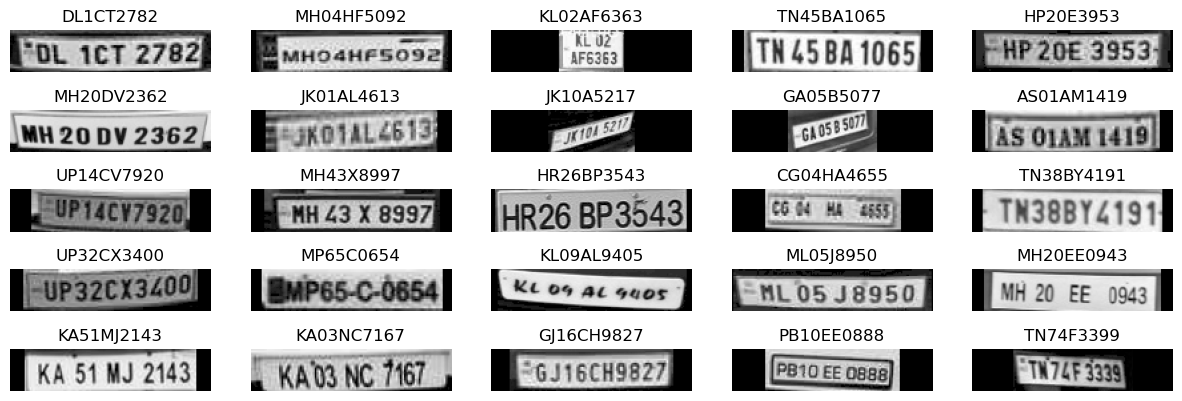

In [12]:
show_images(images[:25], labels[:25])

In [13]:
augmentor = LicensePlateImageAugmentor(IMAGE_WIDTH, IMAGE_HEIGHT, background_images)

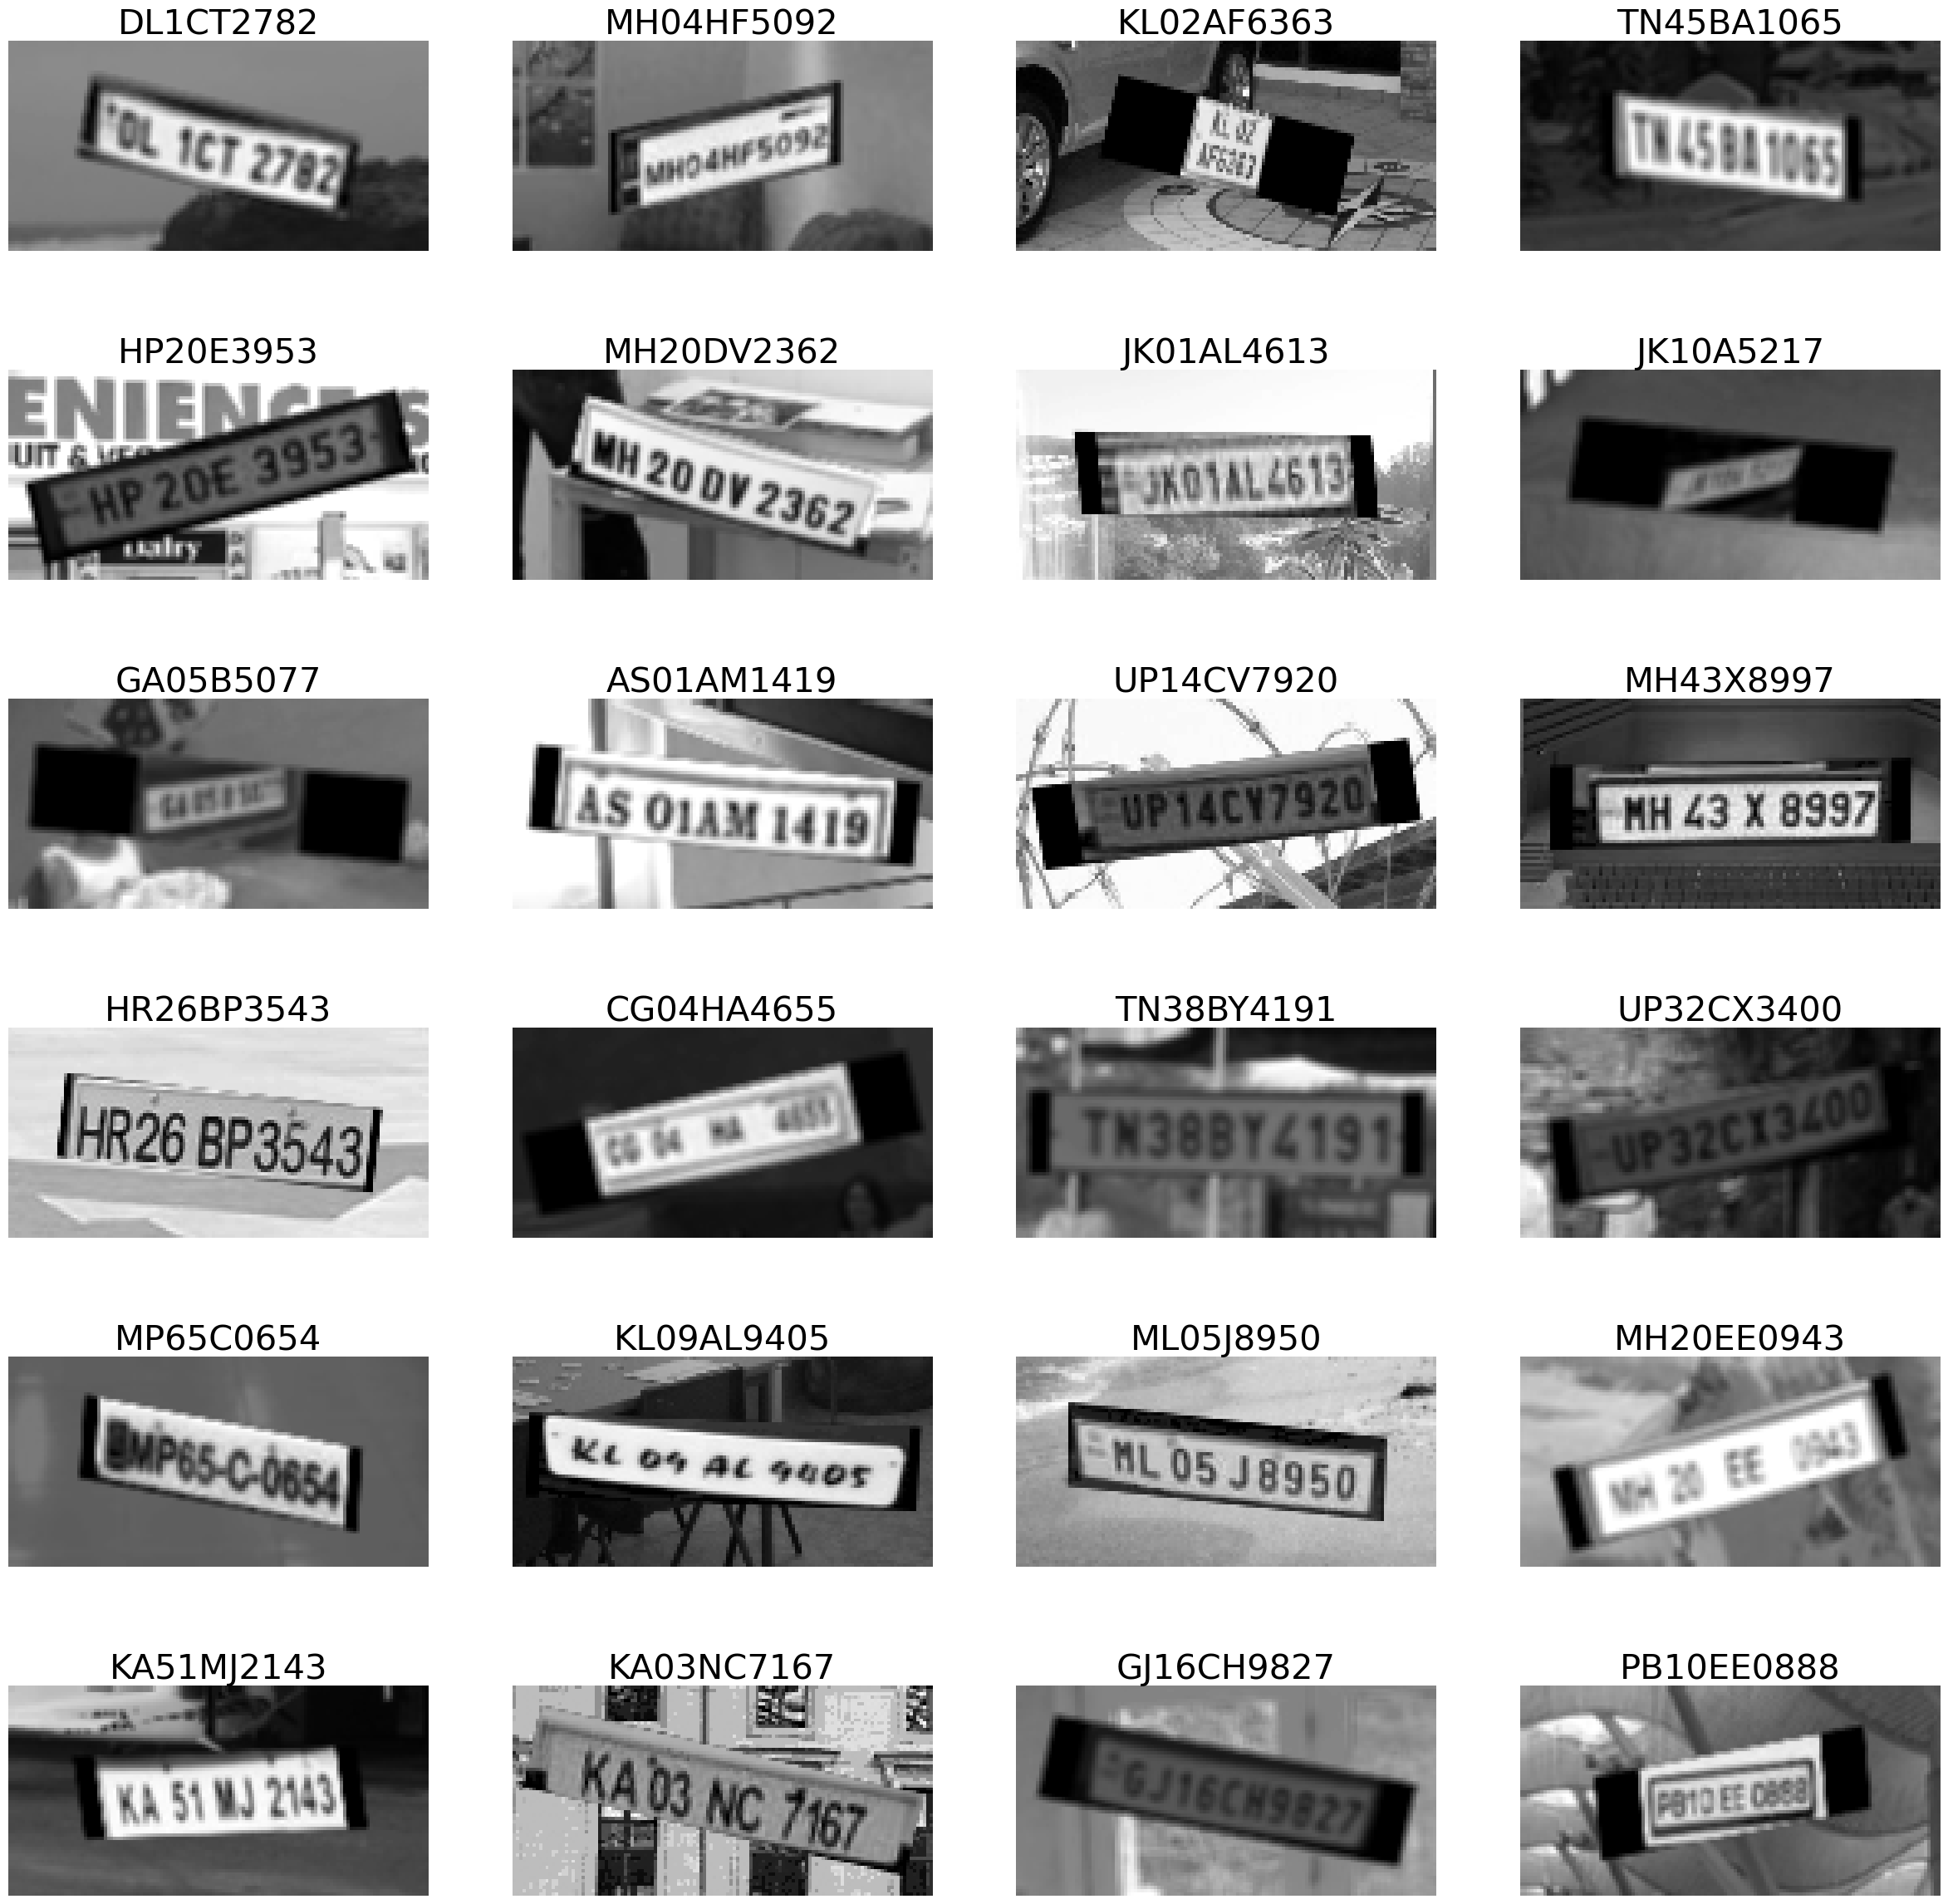

In [14]:
cols = 4
rows = 6

image_index = 0
fig, axarr = plt.subplots(rows, cols, figsize=(30, 30))
for r in range(rows):
    for c in range(cols):
        image = images[image_index]
        image = augmentor.generate_plate_image(image)
        axarr[r, c].axis("off")
        axarr[r, c].title.set_size(30)
        axarr[r, c].title.set_text(labels[image_index].decode())
        axarr[r, c].imshow(image, cmap='gray')
        image_index += 1

plt.show()

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Train dataset size:      {}".format(X_train.shape[0]))
print("Validation dataset size: {}".format(X_val.shape[0]))
print("Test dataset size:       {}".format(X_test.shape[0]))

Train dataset size:      380
Validation dataset size: 96
Test dataset size:       119


In [16]:
import itertools
import numpy as np


class LabelCodec:
    ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789- "

    # Translation of characters to unique numerical classes
    @staticmethod
    def encode_number(number):
        return list(map(lambda c: LabelCodec.ALPHABET.index(c), number))

    # Reverse translation of numerical classes back to characters
    @staticmethod
    def decode_number(label):
        return ''.join(list(map(lambda x: LabelCodec.ALPHABET[int(x)], label)))

    @staticmethod
    def decode_prediction(prediction):
        out_best = list(np.argmax(prediction, axis=1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(LabelCodec.ALPHABET):
                outstr += LabelCodec.ALPHABET[c]
        return outstr

In [17]:
import random

import numpy as np


class LicensePlateDatasetGenerator:
    def __init__(self, images, labels, img_w, img_h, downsample_factor, max_text_len, batch_size, augmentor):

        self.img_w = img_w
        self.img_h = img_h
        self.max_text_len = max_text_len
        self.batch_size = batch_size
        self.input_length = img_w // downsample_factor

        self.images = images
        self.labels = labels
        self.numImages = self.labels.shape[0]

        self.indexes = np.asarray(range(self.numImages))
        random.shuffle(self.indexes)
        self.batch_index = 0

        self.augmentor = augmentor

    def next_batch(self):

        if self.batch_index >= (self.numImages // self.batch_size):
            self.batch_index = 0
            random.shuffle(self.indexes)

        current_index = self.batch_index * self.batch_size
        batch_indexes = self.indexes[current_index:current_index + self.batch_size]
        self.batch_index += 1
        return self.images[batch_indexes], self.labels[batch_indexes]

    def generator(self, passes=np.inf):
        # initialize the epoch count
        epochs = 0

        # keep looping infinitely -- the model will stop once we have
        # reach the desired number of epochs
        while epochs < passes:

            data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            labels = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * self.input_length
            label_length = np.zeros((self.batch_size, 1))

            x_data, y_data = self.next_batch()

            for i, (image, number) in enumerate(zip(x_data, y_data)):
                image = self.augmentor.generate_plate_image(image)
                data[i] = np.expand_dims(image.T, -1)
                text_length = len(number)
                labels[i, 0:text_length] = LabelCodec.encode_number(number.decode())
                label_length[i] = text_length

            yield {'input': data, 'labels': labels, 'input_length': input_length, 'label_length': label_length}

            # increment the total number of epochs
            epochs += 1

In [18]:
train_generator = LicensePlateDatasetGenerator(X_train, y_train, IMAGE_WIDTH, IMAGE_HEIGHT,
                                               DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                               augmentor)

val_generator = LicensePlateDatasetGenerator(X_val, y_val, IMAGE_WIDTH, IMAGE_HEIGHT,
                                             DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                             augmentor)

test_generator = LicensePlateDatasetGenerator(X_test, y_test, IMAGE_WIDTH, IMAGE_HEIGHT,
                                              DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                              augmentor)

/home/lee/anaconda3/envs/tfsetup/lib/python3.10/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


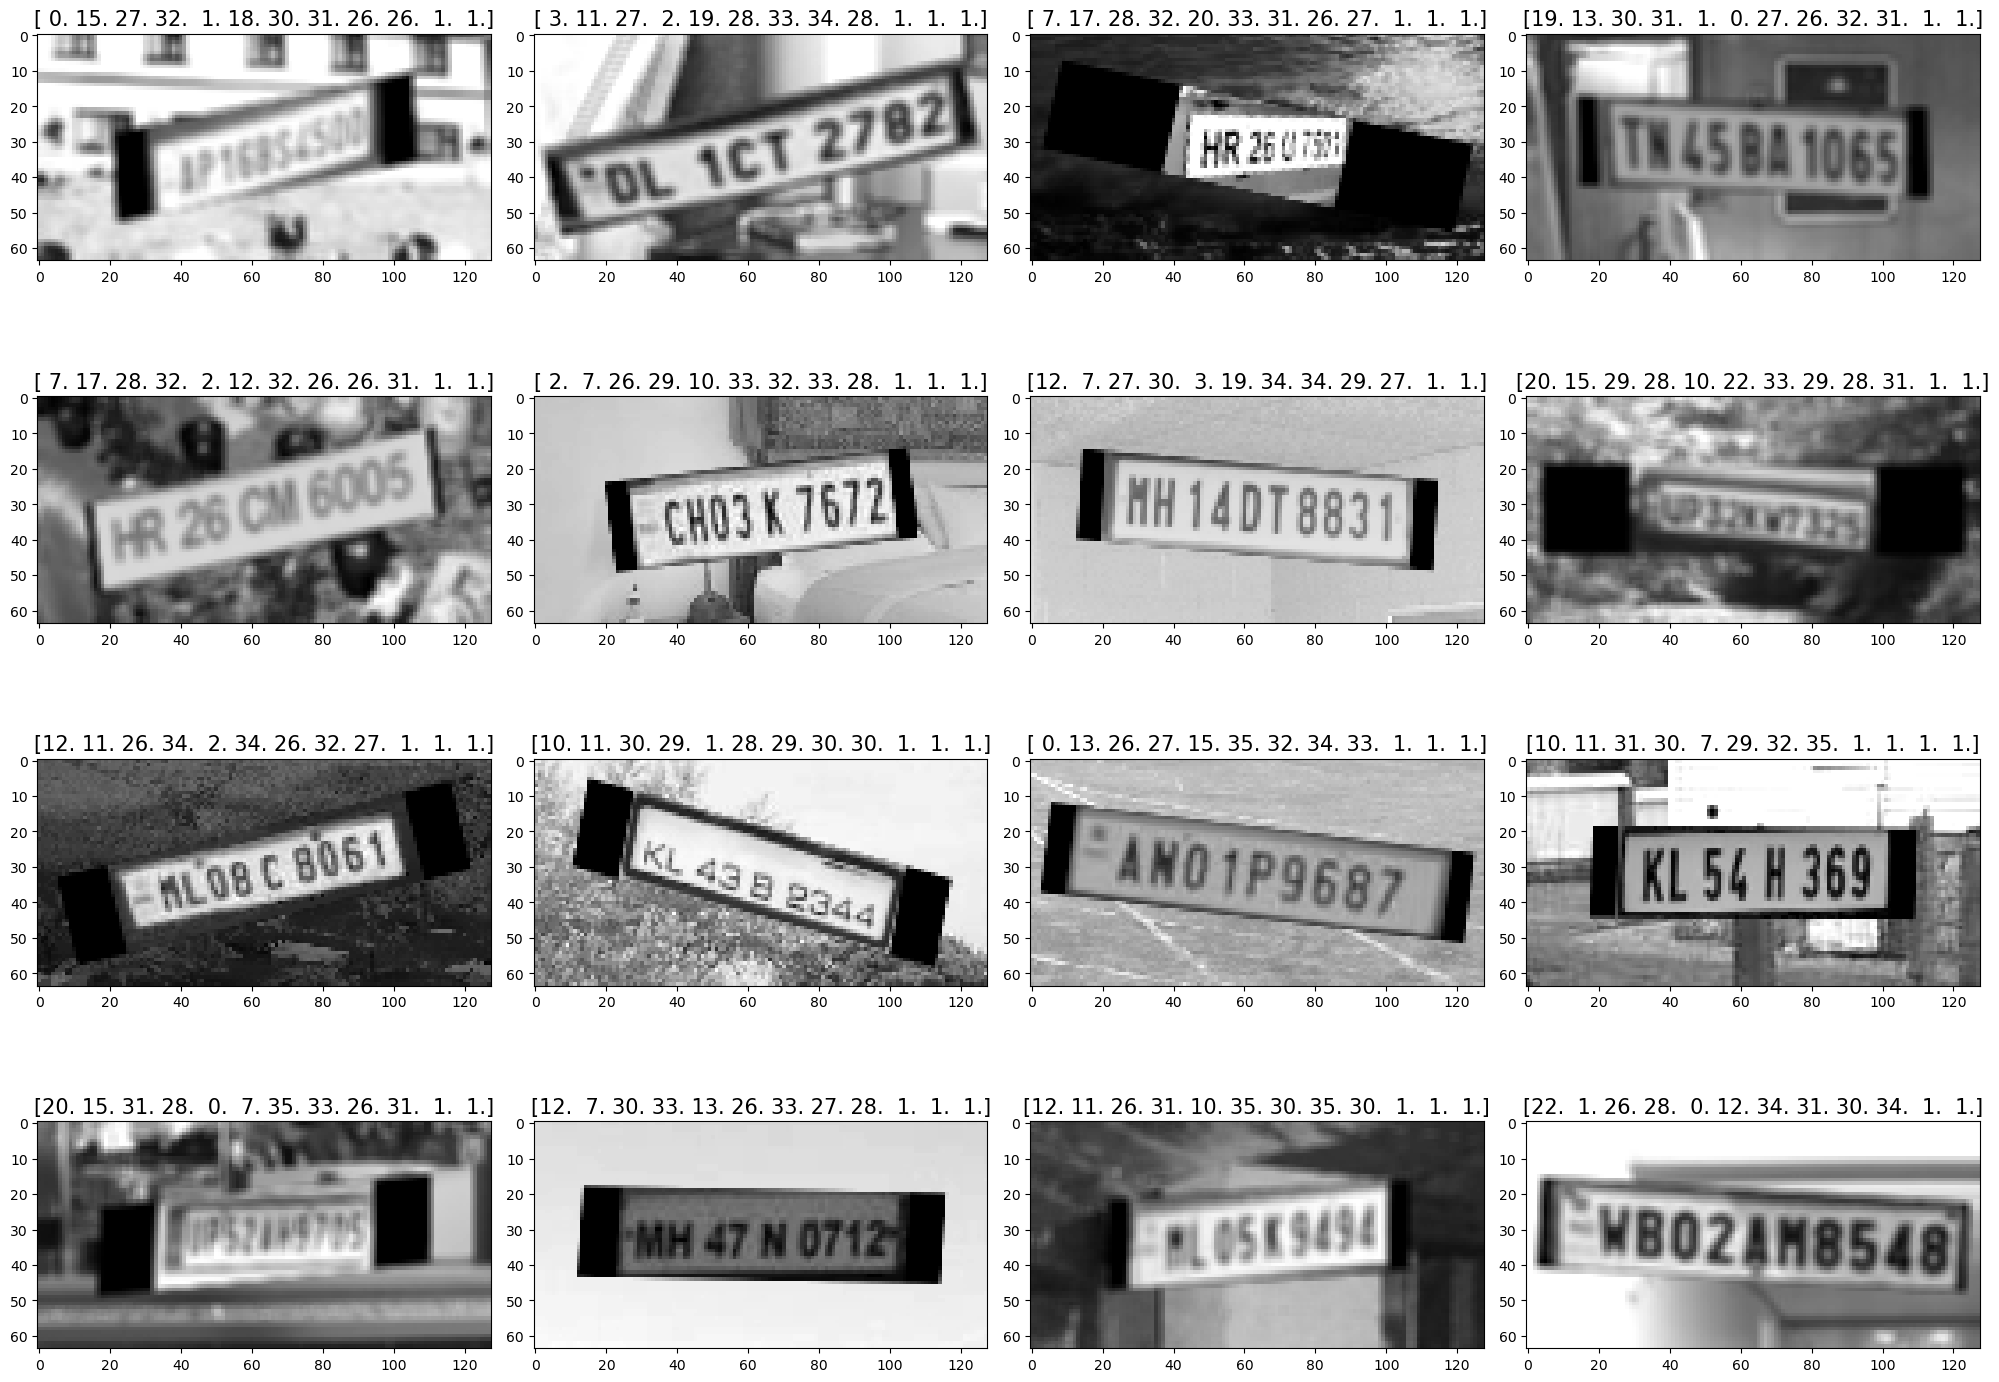

In [19]:
inputs = next(train_generator.generator())

def plotImages(images_arr, labels, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(20,15))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        img = img.T.reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        ax.title.set_size(15)
        ax.title.set_text(label)
        ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()
        
plotImages(inputs["input"], inputs["labels"], int(16 / 4), 4)

In [20]:
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, LSTM, GRU, Bidirectional,
    Input, Dense, Activation, Reshape, BatchNormalization, add, concatenate
)


class OCR:
    @staticmethod
    def conv_bgru(input_shape, output_size):
        conv_filters = 16
        kernel_size = (3, 3)
        pool_size = 2
        time_dense_size = 32
        rnn_size = 512

        input_data = Input(name="input", shape=input_shape)

        cnn = Conv2D(conv_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_data)
        cnn = BatchNormalization()(cnn)
        cnn = Activation('relu')(cnn)
        cnn = MaxPooling2D(pool_size=(pool_size, pool_size))(cnn)

        cnn = Conv2D(conv_filters, kernel_size, padding='same', kernel_initializer='he_normal')(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = Activation('relu')(cnn)
        cnn = MaxPooling2D(pool_size=(pool_size, pool_size))(cnn)

        # CNN to RNN
        shape = cnn.get_shape()
        cnn = Reshape((shape[1], shape[2] * shape[3]))(cnn)
        dense = Dense(time_dense_size, activation='relu', kernel_initializer='he_normal')(cnn)

        # RNN layer
        bgru = Bidirectional(GRU(units=rnn_size, return_sequences=True), merge_mode="sum")(dense)
        bgru = BatchNormalization()(bgru)
        bgru = Bidirectional(GRU(units=rnn_size, return_sequences=True), merge_mode="concat")(bgru)
        bgru = BatchNormalization()(bgru)

        # transforms RNN output to character activations:
        dense = Dense(output_size, kernel_initializer='he_normal')(bgru)
        output_data = Activation("softmax", name="output")(dense)

        return input_data, output_data

    @staticmethod
    def conv_blstm(input_shape, output_size):
        conv_filters = 16
        kernel_size = (3, 3)
        pool_size = 2
        time_dense_size = 32
        rnn_size = 512

        input_data = Input(name="input", shape=input_shape)

        cnn = Conv2D(conv_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_data)
        cnn = BatchNormalization()(cnn)
        cnn = Activation('relu')(cnn)
        cnn = MaxPooling2D(pool_size=(pool_size, pool_size))(cnn)

        cnn = Conv2D(conv_filters, kernel_size, padding='same', kernel_initializer='he_normal')(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = Activation('relu')(cnn)
        cnn = MaxPooling2D(pool_size=(pool_size, pool_size))(cnn)

        # CNN to RNN
        shape = cnn.get_shape()
        cnn = Reshape((shape[1], shape[2] * shape[3]))(cnn)
        dense = Dense(time_dense_size, activation='relu', kernel_initializer='he_normal')(cnn)

        # RNN layer
        blsmt = Bidirectional(LSTM(units=rnn_size, return_sequences=True), merge_mode="sum")(dense)
        blsmt = BatchNormalization()(blsmt)
        blsmt = Bidirectional(LSTM(units=rnn_size, return_sequences=True), merge_mode="concat")(blsmt)
        blsmt = BatchNormalization()(blsmt)

        # transforms RNN output to character activations:
        dense = Dense(output_size, kernel_initializer='he_normal')(blsmt)
        output_data = Activation("softmax", name="output")(dense)

        return input_data, output_data

    @staticmethod
    def vgg_bgru(input_shape, output_size):

        input_data = Input(name='input', shape=input_shape, dtype='float32')  # (None, 128, 64, 1)
        cnn = OCR.__mini_vgg__(input_data)

        # CNN to RNN
        shape = cnn.get_shape()
        cnn = Reshape((shape[1], shape[2] * shape[3]))(cnn)
        dense = Dense(64, activation='relu', kernel_initializer='he_normal')(cnn)  # (None, 32, 64)

        # RNN layer
        bgru = Bidirectional(GRU(units=256, return_sequences=True, dropout=0.2), merge_mode="sum")(dense)
        bgru = BatchNormalization()(bgru)
        bgru = Bidirectional(GRU(units=256, return_sequences=True, dropout=0.2), merge_mode="concat")(bgru)
        bgru = BatchNormalization()(bgru)

        # transforms RNN output to character activations:
        dense = Dense(output_size, kernel_initializer='he_normal')(bgru)  # (None, 32, 42)
        output_data = Activation('softmax', name='output')(dense)

        return input_data, output_data

    @staticmethod
    def __mini_vgg__(input_data):

        cnn = Conv2D(32, (3, 3), activation='relu', padding='same')(input_data)
        cnn = BatchNormalization()(cnn)
        cnn = Conv2D(32, (3, 3), activation='relu', padding='same')(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = MaxPooling2D(pool_size=(2, 2))(cnn)

        cnn = Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = MaxPooling2D(pool_size=(2, 2))(cnn)

        return cnn

    @staticmethod
    def __vgg__(input_data):

        cnn = Conv2D(64, (3, 3), activation='relu', padding='same')(input_data)
        cnn = MaxPooling2D(pool_size=(2, 2), strides=2)(cnn)

        cnn = Conv2D(128, (3, 3), activation='relu', padding='same')(cnn)
        cnn = MaxPooling2D(pool_size=(2, 2), strides=2)(cnn)

        cnn = Conv2D(256, (3, 3), activation='relu', padding='same')(cnn)

        cnn = Conv2D(256, (3, 3), activation='relu', padding='same')(cnn)
        cnn = MaxPooling2D(pool_size=(1, 2))(cnn)

        cnn = Conv2D(512, (3, 3), activation='relu', padding='same')(cnn)
        cnn = BatchNormalization()(cnn)

        cnn = Conv2D(512, (3, 3), activation='relu', padding='same')(cnn)
        cnn = BatchNormalization()(cnn)
        cnn = MaxPooling2D(pool_size=(1, 2))(cnn)

        cnn = Conv2D(512, (2, 2), activation='relu', padding='same')(cnn)

        return cnn

In [21]:
import os

from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


class TrainHelper:
    @staticmethod
    def get_optimizer(optimizer):
        if optimizer == "sdg":
            return SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
        if optimizer == "rmsprop":
            return RMSprop(learning_rate=0.01)
        if optimizer == "adam":
            return Adam(learning_rate=0.01)
        if optimizer == "adagrad":
            return Adagrad(learning_rate=0.01)
        if optimizer == "adadelta":
            return Adadelta(learning_rate=1.0)

    @staticmethod
    def get_callbacks(output_dir, model_name, optimizer, model_weigths_path):
        logdir = os.path.join(output_dir, optimizer, 'logs')
        chkpt_filepath = model_name + '--{epoch:02d}--{loss:.3f}--{val_loss:.3f}.h5'

        callbacks = [
            EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1),
            ModelCheckpoint(filepath=model_weigths_path, monitor='val_loss', save_best_only=True,
                            save_weights_only=True, verbose=1),
            TensorBoard(log_dir=logdir)]

        if optimizer in ["sdg", "rmsprop"]:
            callbacks.append(
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.01,
                                  cooldown=0, min_lr=0))

        return callbacks

In [22]:
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras import Input
from tensorflow.keras.models import Model
    
class CTCLoss(tf.keras.losses.Loss):

    def __init__(self, input_length, label_length, name='CTCLoss'):
        super().__init__(name=name)
        self.input_length = input_length
        self.label_length = label_length

    def call(self, labels, predictions):
        return tf.keras.backend.ctc_batch_cost(labels, predictions, self.input_length, self.label_length)

tf.compat.v1.disable_eager_execution()

labels = Input(name='labels', shape=(MAX_TEXT_LEN,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')

inputs, outputs = OCR.conv_bgru((IMAGE_WIDTH, IMAGE_HEIGHT, 1), len(LabelCodec.ALPHABET) + 1)

train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=outputs)
train_model.add_loss(CTCLoss(input_length, label_length)(labels, outputs))
train_model.compile(loss=None, optimizer=TrainHelper.get_optimizer(OPTIMIZER))

predict_model = Model(inputs=inputs, outputs=outputs)
predict_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2023-01-27 13:23:15.244914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2023-01-27 13:23:15.244970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: LeeAarthi
2023-01-27 13:23:15.244981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: LeeAarthi
2023-01-27 13:23:15.245240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.108.3
2023-01-27 13:23:15.245276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.86.1
2023-01-27 13:23:15.245287: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.86.1 does not match DSO version 510.108.3 -- cannot find working devices in this configuration
2023-01-27 13:

2023-01-27 13:23:20.512180: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss/strided_slice_5/stack' id:1588 op device:{requested: '', assigned: ''} def:{{{node CTCLoss/strided_slice_5/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-01-27 13:23:20.657157: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss/strided_slice_5/stack_1' id:1589 op device:{requested: '', assigned: ''} def:{{{node CTCLoss/strided_slice_5/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modif

2023-01-27 13:23:22.726572: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss/boolean_mask_1/strided_slice_2/stack_1' id:1615 op device:{requested: '', assigned: ''} def:{{{node CTCLoss/boolean_mask_1/strided_slice_2/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-01-27 13:23:22.870415: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss/boolean_mask_1/strided_slice_2/stack_2' id:1616 op device:{requested: '', assigned: ''} def:{{{node CTCLoss/boolean_mask_1/strided_slice_2/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no eff

2023-01-27 13:23:24.780879: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss/strided_slice_2/stack_2' id:1517 op device:{requested: '', assigned: ''} def:{{{node CTCLoss/strided_slice_2/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-01-27 13:23:24.918099: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss/scan/TensorArrayV2_1/element_shape' id:1533 op device:{requested: '', assigned: ''} def:{{{node CTCLoss/scan/TensorArrayV2_1/element_shape}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 12>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in t

2023-01-27 13:23:26.884812: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss/boolean_mask/Prod/reduction_indices' id:1566 op device:{requested: '', assigned: ''} def:{{{node CTCLoss/boolean_mask/Prod/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-01-27 13:23:27.019785: W tensorflow/c/c_api.cc:291] Operation '{name:'CTCLoss/boolean_mask/strided_slice/stack' id:1562 op device:{requested: '', assigned: ''} def:{{{node CTCLoss/boolean_mask/strided_slice/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trig

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 64, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 128, 64, 16)       160       
                                                                 
 batch_normalization (BatchN  (None, 128, 64, 16)      64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 64, 16)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 32, 16)        2320

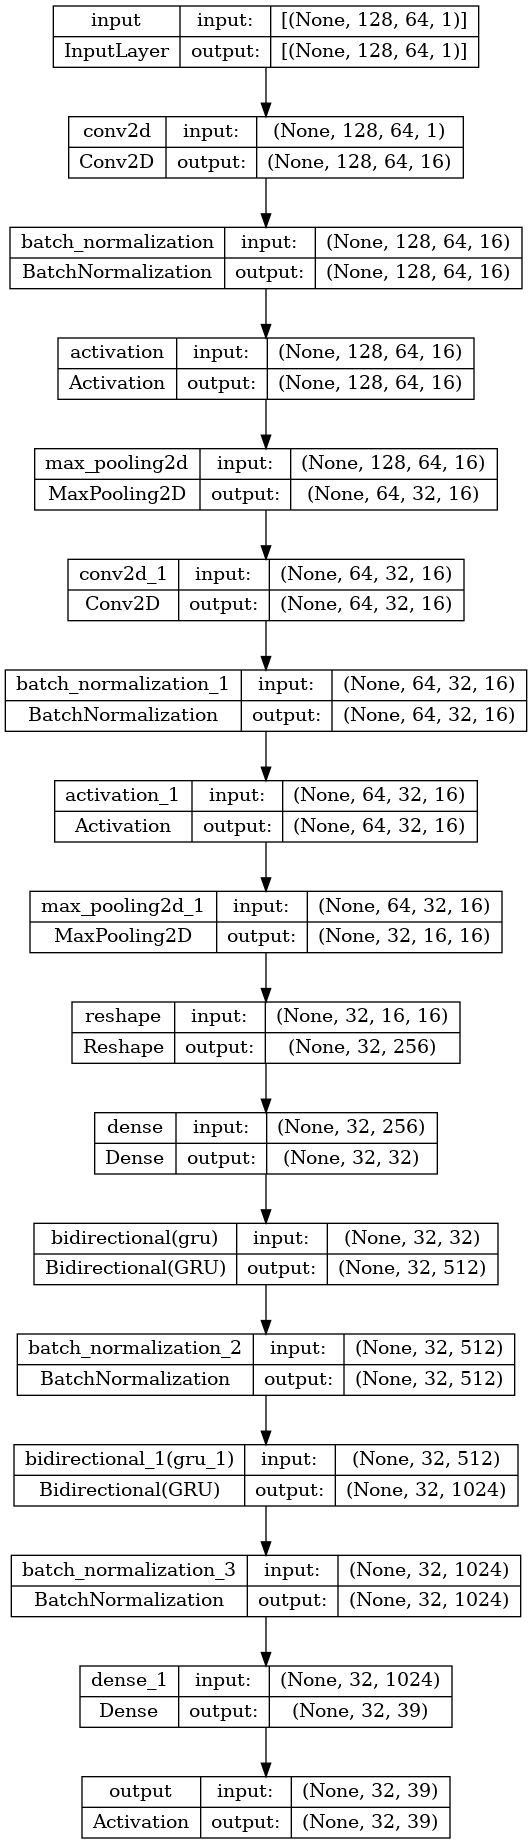

In [23]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

model_architecture_file = os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + '.png'
plot_model(predict_model, to_file=model_architecture_file, show_shapes=True)
Image(filename=model_architecture_file, width=400)

In [24]:
history = train_model.fit(
    train_generator.generator(),
    steps_per_epoch=16 // BATCH_SIZE,
    validation_data=val_generator.generator(),
    validation_steps=16 // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=TrainHelper.get_callbacks(OUTPUT_PATH, MODEL_NAME, OPTIMIZER, MODEL_WEIGHTS_PATH), verbose=1)

Epoch 1/1000
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2023-01-27 13:24:04.341527: W tensorflow/c/c_api.cc:291] Operation '{name:'batch_normalization_3/cond_3/Identity' id:1442 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_3/cond_3/Identity}} = Identity[T=DT_FLOAT, _has_manual_control_dependencies=true](batch_normalization_3/cond_3)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


InvalidArgumentError: Graph execution error:

Node 'training/Adagrad/gradients/gradients/bidirectional_1/forward_gru_1_1/while_grad/bidirectional_1/forward_gru_1_1/while_grad': Connecting to invalid output 51 of source node bidirectional_1/forward_gru_1_1/while which has 51 outputs. Try using tf.compat.v1.experimental.output_all_intermediates(True).